Show the common image transformatons used in image registration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp
import cv2
from scipy.ndimage import map_coordinates, gaussian_filter

## Define transformations

In [2]:
# Define the source and destination points for the square
def get_square_points(size=100, square_size=40):
    """Generate the corners, midpoints, and inner control points of the square."""
    center = size // 2
    half_size = square_size // 2
    quarter_size = square_size // 4
    
    # Define the source points (corners, midpoints, and center)
    source_points = np.array([
        [center - half_size, center - half_size],  # Top-left
        [center + half_size, center - half_size],  # Top-right
        [center + half_size, center + half_size],  # Bottom-right
        [center - half_size, center + half_size],  # Bottom-left
        [center, center - half_size],              # Mid-top
        [center + half_size, center],              # Mid-right
        [center, center + half_size],              # Mid-bottom
        [center - half_size, center],              # Mid-left
        [center, center],                          # Center point
        [center - quarter_size, center - quarter_size],  # Quarter-top-left
        [center + quarter_size, center - quarter_size],  # Quarter-top-right
        [center + quarter_size, center + quarter_size],  # Quarter-bottom-right
        [center - quarter_size, center + quarter_size]   # Quarter-bottom-left
    ])
    return source_points


def get_destination_points(source_points):
    """Generate non-symmetric wavy destination points with varying 'bump' sizes."""
    # Copy the source points and apply varied local deformations
    destination_points = source_points.copy()

    center = np.mean(source_points, axis=0)
    destination_points = (destination_points - center).astype(float) * 0.65 + center

    # Apply larger random displacements to create more "waves"
    # Corners of the square
    destination_points[0] += [-6, -8]  # Top-left corner
    destination_points[1] += [7, -6]   # Top-right corner
    destination_points[2] += [8, 5]    # Bottom-right corner
    destination_points[3] += [-5, 7]   # Bottom-left corner
    
    # Midpoints along the edges
    destination_points[4] += [-2, -5]  # Mid-top (more wavy bump)
    destination_points[5] += [5, 1]    # Mid-right (smaller bump)
    destination_points[6] += [0, 6]    # Mid-bottom (larger wave)
    destination_points[7] += [-6, -1]  # Mid-left (different bump size)
    
    # Center remains unchanged to anchor the image
    destination_points[8] += [0, 0]  # Center point
    
    # Quarter points (additional smaller bumps)
    destination_points[9] += [-4, -3]  # Quarter-top-left
    destination_points[10] += [3, -2]  # Quarter-top-right
    destination_points[11] += [4, 3]   # Quarter-bottom-right
    destination_points[12] += [-3, 4]  # Quarter-bottom-left
    
    return destination_points

In [3]:
def translate_image(image, tx, ty):
    """Translate an image by tx and ty from the center."""
    transform = AffineTransform(translation=(tx, ty))
    return center_based_transform(image, transform)


def rotate_image(image, angle):
    """Rotate an image by a given angle (in degrees) around the center."""
    transform = AffineTransform(rotation=np.deg2rad(angle))
    return center_based_transform(image, transform)


def scale_image(image, scale_x, scale_y):
    """Scale an image by scale_x and scale_y around the center."""
    transform = AffineTransform(scale=(scale_x, scale_y))
    return center_based_transform(image, transform)


def shear_image(image, shear_angle):
    """Shear an image by a given shear angle (in degrees) around the center."""
    transform = AffineTransform(shear=np.deg2rad(shear_angle))
    return center_based_transform(image, transform)


def perspective_image(image):
    """Apply a classic perspective transformation where the top is smaller than the bottom."""
    size = image.shape[0]
    center = size // 2
    src_points = np.array([[center - 20, center - 20], [center + 20, center - 20], 
                           [center + 20, center + 20], [center - 20, center + 20]])
    dst_points = np.array([[center - 10, center - 30], [center + 10, center - 30], 
                           [center + 20, center + 20], [center - 20, center + 20]])
    
    matrix = cv2.getPerspectiveTransform(src_points.astype(np.float32), dst_points.astype(np.float32))
    transformed = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return transformed


def tps_transform(image, source_points, destination_points):
    """Apply TPS (Thin Plate Spline) transformation using OpenCV."""
    # Create the Thin Plate Spline Transformer
    tps = cv2.createThinPlateSplineShapeTransformer()
    
    # Create matches between the source and destination points
    matches = [cv2.DMatch(i, i, 0) for i in range(len(source_points))]
    
    # Estimate the transformation between the source and destination points
    tps.estimateTransformation(np.array(destination_points).reshape((-1, len(source_points), 2)),
                               np.array(source_points).reshape((-1, len(source_points), 2)),
                               matches)
    
    # Apply the TPS warp to the image
    output_image = tps.warpImage(image)
    
    return output_image, tps

## Plotting:

In [4]:
def create_square_image(size=100, square_size=40):
    """Create an image with a centered square."""
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    half_size = square_size // 2
    img[center-half_size:center+half_size, center-half_size:center+half_size] = 255
    return img


def plot_transformation(original, transformed, title, ax):
    """Plot the original and transformed image overlays."""
    ax.imshow(original, cmap='Blues', alpha=0.6, label='Source Space')  # Original square in blue
    ax.imshow(transformed, cmap='Reds', alpha=0.6, label='Transformed Space')  # Transformed square in red
    ax.set_title(title)
    ax.axis('off')


def center_based_transform(image, transform):
    """Apply a transformation around the center of the image."""
    center = np.array(image.shape) / 2
    tform_to_center = AffineTransform(translation=-center)
    tform_from_center = AffineTransform(translation=center)
    return warp(image, (tform_to_center + transform + tform_from_center).inverse)

## Define transformation parameters

In [5]:
# Define transformation parameters (adjustable)
translation_x = 30
translation_y = 15
rotation_angle = 45  # in degrees
scaling_x = 1.5
scaling_y = 0.5
shearing_angle = 30  # in degrees

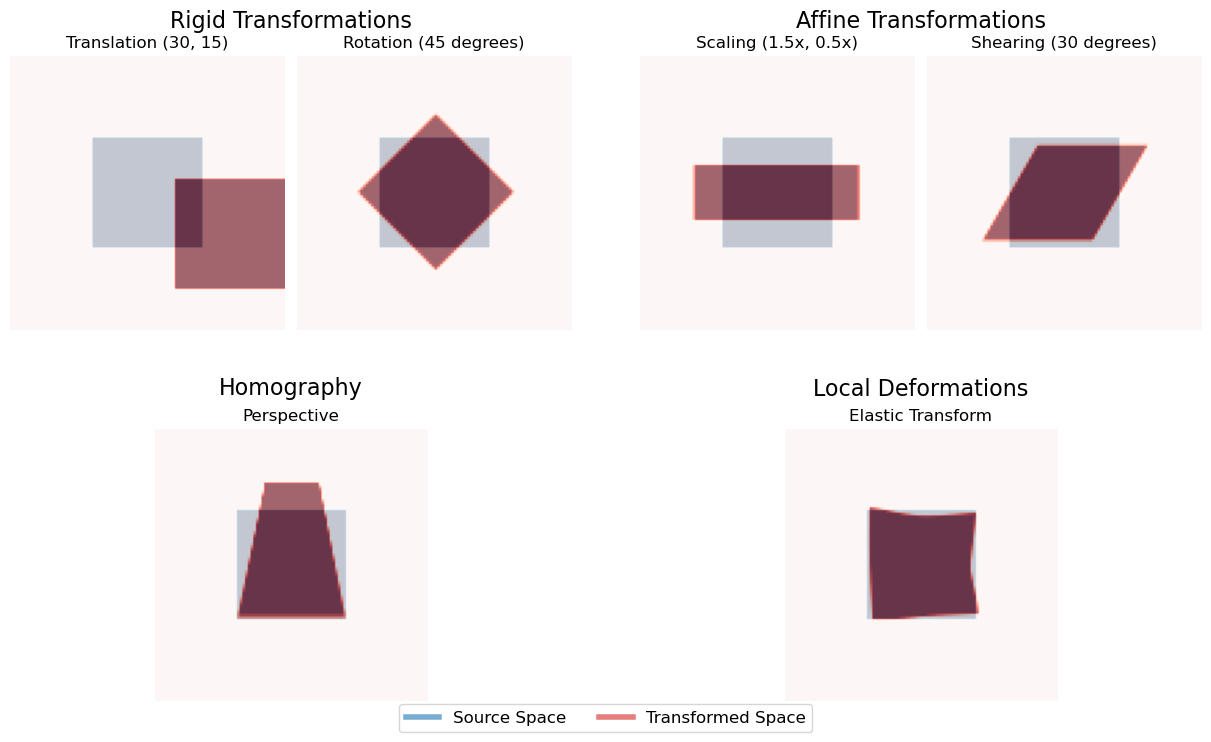

In [6]:
# Create the original square image
image = create_square_image()

# Create the figure
fig = plt.figure(layout='constrained', figsize=(12, 7))
subfigs = fig.subfigures(2, 2, wspace=0.1, hspace=0.1)

# Rigid Transformations (Translation, Rotation)
rigid_subfig = subfigs[0, 0]
rigid_axs = rigid_subfig.subplots(1, 2)
rigid_subfig.suptitle("Rigid Transformations", fontsize=16)
plot_transformation(image, translate_image(image, translation_x, translation_y), f'Translation ({translation_x}, {translation_y})', rigid_axs[0])
plot_transformation(image, rotate_image(image, rotation_angle), f'Rotation ({rotation_angle} degrees)', rigid_axs[1])

# Affine Transformations (Scaling, Shearing)
affine_subfig = subfigs[0, 1]
affine_axs = affine_subfig.subplots(1, 2)
affine_subfig.suptitle("Affine Transformations", fontsize=16)
plot_transformation(image, scale_image(image, scaling_x, scaling_y), f'Scaling ({scaling_x}x, {scaling_y}x)', affine_axs[0])
plot_transformation(image, shear_image(image, shearing_angle), f'Shearing ({shearing_angle} degrees)', affine_axs[1])

# Homography (Perspective)
homography_subfig = subfigs[1, 0]
homography_axs = homography_subfig.subplots(1, 1)
homography_subfig.suptitle("Homography", fontsize=16)
plot_transformation(image, perspective_image(image), 'Perspective', homography_axs)

source_points = get_square_points()  # Get the source points (square corners)
destination_points = get_destination_points(source_points)  # Define destination points with deformation
local_subfig = subfigs[1, 1]
local_axs = local_subfig.subplots(1, 1)
local_subfig.suptitle("Local Deformations", fontsize=16)
transformed_image, _ = tps_transform(image, source_points, destination_points)
plot_transformation(image, transformed_image, 'Elastic Transform', local_axs)

handles = [plt.Line2D([0], [0], color='#1f77b4', lw=4, alpha=0.6, label='Source Space'),  # Blue from 'Blues' colormap
           plt.Line2D([0], [0], color='#d62728', lw=4, alpha=0.6, label='Transformed Space')]  # Red from 'Reds' colormap

# Move legend below the subplots with enough spacing
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize=12)

# Show the figure
plt.show()

fig.savefig('../static/img/transformations.png', bbox_inches='tight')
